In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1.5)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20

import torch, torch.nn as nn, torch.nn.functional as F
from torch.distributions.categorical import Categorical
from math import pi
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

EPS = 1e-6

def safe_clamp01(x):
    return x.clamp(EPS, 1.0 - EPS)

def logit(x):
    x = safe_clamp01(x)
    return torch.log(x) - torch.log1p(-x)

def sigmoid(y):
    return torch.sigmoid(y)

#print('Python', sys.version)

In [2]:
class dalitz_dataset(Dataset):
    """
    Creates Dalitz dataset following PyTorch dataloader conventions.
    """

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

In [3]:
class MoG1DLogit(nn.Module):
    """
    Predicts K-component MoG on y = logit(x), then adds Jacobian for x in (0,1).
    Head expects an input of shape (..., d_model) and outputs params per position.
    """
    def __init__(self, d_model, K):
        super().__init__()
        self.K = K
        # outputs: [logits_alpha, mu, log_sigma] per component
        self.proj = nn.Linear(d_model, 3 * K)

    def _unpack_params(self, h):
        # h: (..., 3K)
        K = self.K
        logits_alpha, mu, log_sigma = torch.split(h, [K, K, K], dim=-1)
        # softmax mixture weights; stable sigma
        log_alpha = logits_alpha.log_softmax(dim=-1)
        sigma = F.softplus(log_sigma) + 1e-4
        return log_alpha, mu, sigma

    def log_prob(self, h, x):
        """
        h: (..., 3K) from self.proj
        x: (..., 1) in (0,1)
        returns: (...,) log p(x)
        """
        log_alpha, mu, sigma = self._unpack_params(h)
        x = safe_clamp01(x)
        y = logit(x)                           # R
        # log N(y | mu, sigma)
        z = (y - mu) / sigma
        logN = -0.5*(z**2) - torch.log(sigma) - 0.5*torch.log(torch.tensor(2*pi))
        # log-sum-exp over components
        log_p_y = torch.logsumexp(log_alpha + logN, dim=-1)
        # add Jacobian |dy/dx| = 1/(x(1-x))
        logJ = -torch.log(x) - torch.log1p(-x)
        return (log_p_y + logJ.squeeze(-1))

    def sample(self, h):
        log_alpha, mu, sigma = self._unpack_params(h)    # (..., K)
        cat = Categorical(logits=log_alpha)              # samples comp indices
        k = cat.sample().unsqueeze(-1)                   # (..., 1)
        mu_k = mu.gather(-1, k)
        sigma_k = sigma.gather(-1, k)
        y = mu_k + sigma_k * torch.randn_like(mu_k)
        x = sigmoid(y)
        return x.squeeze(-1)


In [4]:
class CausalTransformer1D(nn.Module):
    def __init__(self, d_model=128, nhead=4, num_layers=3, K=16):
        super().__init__()
        self.d_model = d_model
        self.K = K

        # value embedding (1D value -> d_model), plus learned 2-position embedding
        self.val_emb = nn.Linear(1, d_model)
        self.pos_emb = nn.Parameter(torch.zeros(2, d_model))  # positions 0,1

        # stack of TransformerEncoder layers used in decoder-style with a causal mask
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=False, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # one MoG head per position (predicts p(x_i | x_<i))
        self.head = MoG1DLogit(d_model, K)

        # we use a *single* projection applied at each position; that’s fine for len=2

    def _causal_mask(self, L):
        # float mask with -inf above diagonal (prevents attending to the future)
        mask = torch.full((L, L), float('-inf'))
        mask = torch.triu(mask, diagonal=1)
        return mask

    def _encode(self, x_shifted):
        """
        x_shifted: (B, 2) inputs with x0=0, x1=m', x2=theta' (but len=2 here)
        returns hidden H: (B, 2, d_model)
        """
        B, L = x_shifted.shape
        assert L == 2
        # embed values in logit space (helps mixtures with sharp edges)
        v = logit(safe_clamp01(x_shifted)).unsqueeze(-1)           # (B,2,1)
        H = self.val_emb(v) + self.pos_emb.unsqueeze(0)            # (B,2,d)
        H = H.transpose(0,1)                                       # (2,B,d) for Transformer
        H = self.encoder(H, mask=self._causal_mask(L).to(H.device))# causal
        H = H.transpose(0,1)                                       # (B,2,d)
        return H

    def nll(self, x):
        """
        Negative log-likelihood for batch of (m', theta') in (0,1)^2.
        """
        B = x.size(0)
        # build shifted input: x_shifted[:,0]=0  predicts x[:,0]; x_shifted[:,1]=x[:,0] predicts x[:,1]
        x_shifted = torch.zeros_like(x)
        x_shifted[:, 1] = x[:, 0]
        H = self._encode(x_shifted)                                 # (B,2,d)

        # position-wise mixture params and log-probs
        # pos 0 -> p(x0), pos 1 -> p(x1 | x0)
        h_all = self.head.proj(H)                                   # (B,2,3K)
        logp0 = self.head.log_prob(h_all[:, 0, :], x[:, 0:1])
        logp1 = self.head.log_prob(h_all[:, 1, :], x[:, 1:2])
        return -(logp0 + logp1).mean()

    @torch.no_grad()
    def sample(self, N):
        """
        Draw N samples (m', theta') in (0,1)^2.
        """
        device = next(self.parameters()).device
        # Step 1: predict x0 from context [0, ?]
        x_shifted = torch.zeros(N, 2, device=device)
        H = self._encode(x_shifted)                   # context has x0=0, x1 placeholder
        h_all = self.head.proj(H)
        x0 = self.head.sample(h_all[:, 0, :])         # (N,)
        # Step 2: predict x1 from context [x0, ?]
        x_shifted[:, 1] = x0
        H = self._encode(x_shifted)
        h_all = self.head.proj(H)
        x1 = self.head.sample(h_all[:, 1, :])
        return torch.stack([x0, x1], dim=1)           # (N,2)


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [19]:
# Load in Dalitz dataset
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')
# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.8)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert into torch objects
mp_thetap_train = torch.Tensor(mp_thetap_train)
#mp_thetap_val   = torch.Tensor(mp_thetap_val)

trainset = dalitz_dataset(mp_thetap_train)
#valset   = dalitz_dataset(mp_thetap_val)

batch_size = 16384

train_dataloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
#val_dataloader = DataLoader(valset, batch_size = batch_size, shuffle = True)

Training set size:  (2000000, 2) Validation set size:  (8000000, 2)


In [20]:
# ----- device & model -----
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CausalTransformer1D(d_model=128, nhead=4, num_layers=3, K=32).to(device)

# ----- optimizer & (optional) scheduler -----
opt = torch.optim.AdamW(model.parameters(), lr=2e-4, betas=(0.9, 0.999), weight_decay=5e-5)
use_scheduler = True
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=6, verbose=True)

# ----- AMP scaler -----
#scaler = torch.cuda.amp.GradScaler(enabled=(device=='cpu'))

# ----- training hyperparams -----
epochs = 20
grad_clip = 1.0
log_every = 20  # steps

def eval_nll(dataloader: DataLoader) -> float:
    model.eval()
    total, n = 0.0, 0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            loss = model.nll(batch)   # mean over batch
            bs = batch.shape[0]
            total += loss.item() * bs
            n += bs
    return total / max(n, 1)

# ----- training loop -----
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    running, seen = 0.0, 0
    for step, batch in enumerate(train_dataloader, start=1):
        batch = batch.to(device)
        opt.zero_grad(set_to_none=True)
        loss = model.nll(batch)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()

        running += loss.item() * batch.size(0)
        seen += batch.size(0)

        if step % log_every == 0:
            print(f"[epoch {epoch:02d} step {step:04d}] train nll (running mean) = {running/seen:.6f}, lr = {opt.param_groups[0]['lr']:.2e}")

    train_epoch_nll = running / max(seen, 1)
    #val_epoch_nll = eval_nll(val_dataloader)
    print(f"==> epoch {epoch:02d} | train NLL: {train_epoch_nll:.6f}, lr = {opt.param_groups[0]['lr']:.2e}")
    #scheduler.step(val_epoch_nll)

    # save checkpoint
    torch.save({
        'epoch': epoch,
        'model': model.state_dict(),
        'opt': opt.state_dict(),
    }, f"ckpt_transformer_sdp_cpu_epoch{epoch:02d}.pt")

print("Done!")

/home/tony/miniconda3/envs/hadronization_mlrw/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/tony/miniconda3/envs/hadronization_mlrw/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 01 step 0020] train nll (running mean) = -0.191982
[epoch 01 step 0040] train nll (running mean) = -0.491499
[epoch 01 step 0060] train nll (running mean) = -0.618324
[epoch 01 step 0080] train nll (running mean) = -0.695464
[epoch 01 step 0100] train nll (running mean) = -0.747214
[epoch 01 step 0120] train nll (running mean) = -0.784855


  5%|▌         | 1/20 [15:54<5:02:19, 954.69s/it]

==> epoch 01 | train NLL: -0.788022
[epoch 02 step 0020] train nll (running mean) = -0.987600
[epoch 02 step 0040] train nll (running mean) = -0.992659
[epoch 02 step 0060] train nll (running mean) = -0.998389
[epoch 02 step 0080] train nll (running mean) = -1.006219
[epoch 02 step 0100] train nll (running mean) = -1.011583
[epoch 02 step 0120] train nll (running mean) = -1.016883


 10%|█         | 2/20 [32:48<4:56:49, 989.44s/it]

==> epoch 02 | train NLL: -1.017258
[epoch 03 step 0020] train nll (running mean) = -1.048635
[epoch 03 step 0040] train nll (running mean) = -1.049013
[epoch 03 step 0060] train nll (running mean) = -1.050362
[epoch 03 step 0080] train nll (running mean) = -1.051747
[epoch 03 step 0100] train nll (running mean) = -1.052950
[epoch 03 step 0120] train nll (running mean) = -1.053948


 15%|█▌        | 3/20 [48:35<4:34:54, 970.26s/it]

==> epoch 03 | train NLL: -1.054044


 15%|█▌        | 3/20 [50:12<4:44:28, 1004.05s/it]


KeyboardInterrupt: 

In [21]:
model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Samples to generate
N = 100_000

with torch.no_grad():
    mp_thetap_gen = model.sample(N).cpu().numpy()

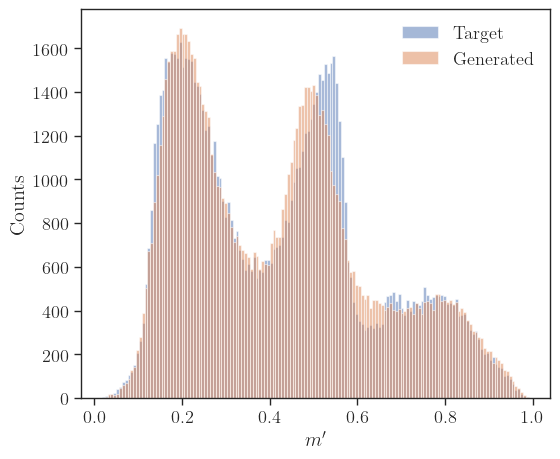

In [22]:
# Visualize 
fig, ax = plt.subplots(figsize=(6,5))

counts, bins, _ = ax.hist(mp_thetap[:N,0], 150, alpha = 0.5, label = r'$\mathrm{Target}$')
ax.hist(mp_thetap_gen[:,0], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$m'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_gen.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_gen.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

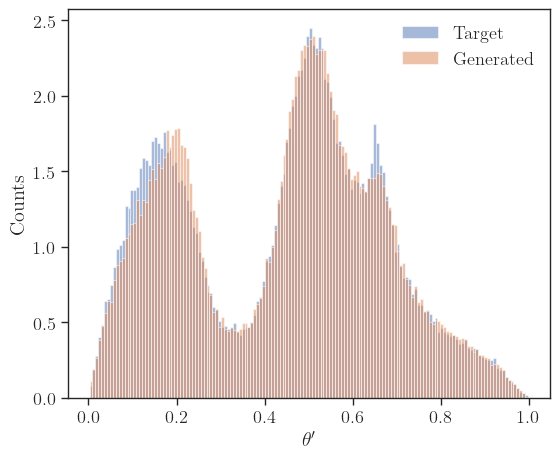

In [23]:
# Visualize 
fig, ax = plt.subplots(figsize=(6,5))

counts, bins, _ = ax.hist(mp_thetap[:N,1], 150, alpha = 0.5, label = r'$\mathrm{Target}$', density = True)
ax.hist(mp_thetap_gen[:,1], bins, alpha=0.5, label = r'$\mathrm{Generated}$', density = True)

ax.set_xlabel( r"$\theta'$")
ax.set_ylabel( r'$\mathrm{Counts}$' )

#ax.text(0.6, 0.8, rf'$\texttt{{K}} = {K}$ \\ $\texttt{{N\_{{samples}}}} = {N}$ \\ $\texttt{{epochs}} = {epochs}$ \\ $\texttt{{N\_{{blocks}}}} = {n_blocks}$', transform=ax.transAxes, fontsize = 10)

ax.legend(loc='best', frameon=False)

fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_gen.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_gen.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

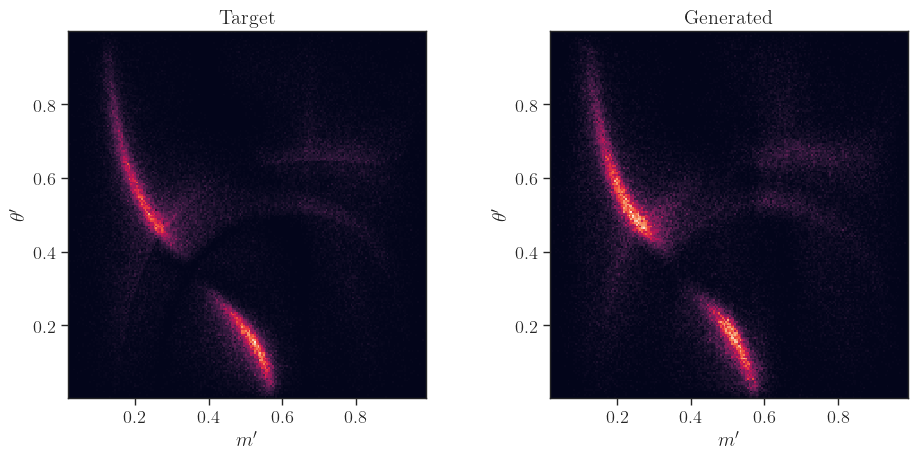

In [13]:
# Visualize 2D Dalitz plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5) )

h_sim, xedges, yedges, _ = ax1.hist2d(mp_thetap[:N,0], mp_thetap[:N,1], 200, rasterized=True)
h_gen, _, _, _ = ax2.hist2d(mp_thetap_gen[:,0], mp_thetap_gen[:,1], bins = [xedges, yedges], rasterized=True)

ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Target}$')
ax1.set_aspect('equal')

ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Generated}$')
ax2.set_aspect('equal')

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_INN_target_vs_gen.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_INN_target_vs_gen.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

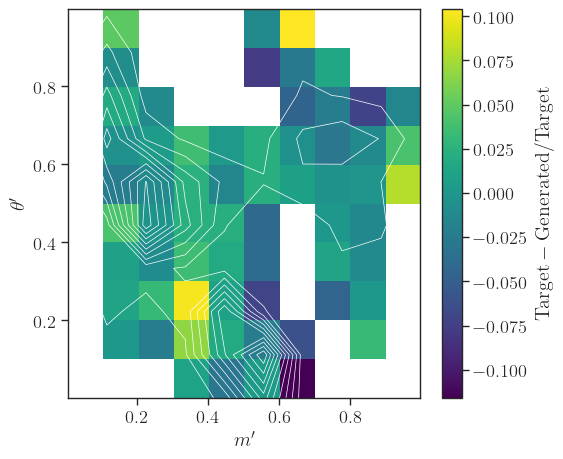

In [57]:
# Plot the per bin chi2 difference ignore bins with 0 entries
fig, ax = plt.subplots( figsize=(6,5) )
h_diff = (h_sim - h_gen) / h_sim
# Get rid of bins with counts less than 1000
h_diff[h_sim < 1000] = None
# Get rid of outliers
#h_diff[h_diff > 0.2] = 0.2
#h_diff[h_diff < -0.2] = -0.2
#h_diff = np.nan_to_num(h_diff)
im = ax.imshow(h_diff.T, origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$\theta'$")
#ax.set_xlim(0, 0.4)
#ax.set_ylim(0.4, 0.5)
fig.colorbar(im, ax=ax, label = r'$\mathrm{Target - Generated / Target}$')
# Overlay a contour of the target distribution
ax.contour(h_sim.T, levels=10, colors='white', linewidths=0.5, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
fig.tight_layout()
fig.savefig(r'figs/D_amplitude_SDP_INN_per_bin_diff.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

In [58]:
h_sim

array([[  110.,   325.,   432.,   575.,   646.,   672.,   725.,   829.,
          709.,   281.],
       [  944.,  2782.,  4553.,  5416.,  6226., 16946., 25944., 17645.,
         9162.,  2942.],
       [  436.,  1390.,  3118.,  5133., 38696., 36267.,  7178.,  1905.,
          845.,   311.],
       [ 1118.,  3371.,  5145.,  3521., 17818., 14665.,  3380.,   567.,
          210.,    78.],
       [ 5098., 23466., 27514.,  2380.,  4264.,  6991.,  1651.,   133.,
          435.,   518.],
       [26108., 43501.,  4318.,  1732.,  1159.,  4203.,  3084.,   766.,
         1411.,  1002.],
       [ 1362.,  1352.,   696.,   465.,   990.,  7347.,  8927.,  4589.,
         2838.,  1268.],
       [  308.,   900.,  1817.,  3017.,  5452.,  6081., 10776.,  3793.,
         1298.,   556.],
       [  455.,  1477.,  2065.,  2789.,  4528.,  3981.,  7783.,  2675.,
          783.,   285.],
       [  103.,   323.,   639.,   733.,   676.,  1096.,  1421.,  1051.,
          457.,    98.]])

In [24]:
# Save the model
torch.save(model.state_dict(), 'models/transformer_D_to_Kpipi_square_Dalitz_amplitude_model1.pth')

In [ ]:
# Load the model

"""
--- MODEL 1 ---
# Hyperparameters
n_train = 2_000_000
n_batch = 25_000
epochs = 40
learning_rate = 0.001
min_learning_rate = 1e-6
n_blocks = 10
n_bins = 12
hidden_features = 100
# No LR scheduler
"""

n_blocks = 10
n_bins = 12
N = 200_000

# Define the model
flow = conjure_flow(num_flows = n_blocks, hidden_features = 100, num_bins = n_bins)

flow.load_state_dict(torch.load('models/INN_spline_D_to_Kpipi_square_Dalitz_amplitude.pth'))
flow.eval()

"""
--- MODEL 2
"""

'\n--- MODEL 2\n'

In [15]:
@torch.no_grad()
def marginal_likelihood(flow, axis = 0, xs = None, nx = 400, ny = 800, 
                        on_unit_box = True, eps = 1e-8, data_range = None, 
                        batch = 65536, device = None):
    """
    Returns xs (np.ndarray of shape (nx,)) and log_likelihood_marginal (np.ndarray of shape (nx,))
    where log_likelihood_marginal[j] ~ log int p(x_axis = xs[j], other) d(other).

    flow: nflows.flows.Flow object
    axis: which axis to project out (0 or 1)
    xs: if provided, use these x values (np.ndarray of shape (nx,))
    nx: if xs is None, number of points along the projected axis
    ny: number of points along the marginalized axis
    on_unit_box: whether the flow was trained on [0,1]^2
    eps: if on_unit_box, avoid infinities by integrating over [eps, 1-eps]
    data_range: if not on_unit_box, the (min,max) for each axis; if None, uses [-3,3]
    batch: eval batch size for flow.log_prob
    device: torch device (default: "cuda" if available else "cpu")

    Returns:
    xs: np.ndarray of shape (nx,)
    log_marg: np.ndarray of shape (nx,)
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    flow = flow.to(device).eval()

    # --- grids in DATA space ---
    if on_unit_box:
        xmin, xmax = eps, 1.0 - eps
        ymin, ymax = eps, 1.0 - eps
    else:
        if data_range is None:
            xmin, xmax = -3.0, 3.0
            ymin, ymax = -3.0, 3.0
        else:
            (xmin, xmax), (ymin, ymax) = data_range

    if xs is None:
        xs = np.linspace(xmin, xmax, nx, dtype=np.float32)
    else:
        xs = np.asarray(xs, dtype=np.float32)
        nx = xs.shape[0]

    ys = np.linspace(ymin, ymax, ny, dtype=np.float32)

    # Build full grid for evaluation: (ny * nx, 2)
    if axis == 0:
        XX = np.tile(xs, (ny, 1))                  # shape (ny, nx)
        YY = np.tile(ys[:, None], (1, nx))         # shape (ny, nx)
    else:
        XX = np.tile(ys[:, None], (1, nx))         # integrate over x if axis==1
        YY = np.tile(xs, (ny, 1))

    grid = np.stack([XX.ravel(), YY.ravel()], axis=1).astype(np.float32)
    grid_t = torch.from_numpy(grid).to(device)

    # Evaluate log p(x) on the grid (batched to be memory-safe)
    outs = []
    for i in range(0, grid_t.shape[0], batch):
        outs.append(flow.log_prob(grid_t[i:i+batch]))
    logp = torch.cat(outs, dim=0).view(ny, nx)     # reshape so axis 0 is the marginalized dim

    # Numerical integral: log ∫ p(x,y) dy ≈ logsumexp_y [ log p(x,y) ] + log Δy
    dy = (ymax - ymin) / (ny - 1)
    log_marg = torch.logsumexp(logp, dim=0) + torch.log(torch.tensor(dy, device=device))

    # CPU numpy outputs
    return xs, np.exp(log_marg.detach().cpu().numpy())

In [25]:
thetap, pthetap = marginal_likelihood(flow, axis=0, on_unit_box=True, nx=400, ny=1200, eps=1e-8)
mp, pmp = marginal_likelihood(flow, axis=1, on_unit_box=True, nx=400, ny=1200, eps=1e-8)

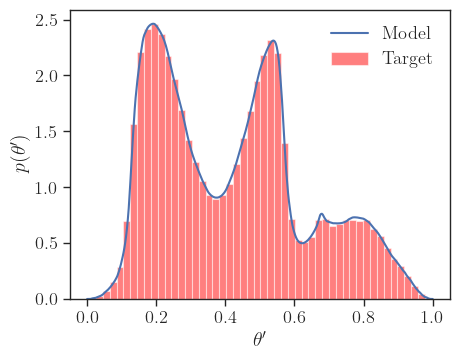

In [28]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

# Plot model likelihood
ax.plot(thetap, pthetap, lw=1.5, label = r'$\mathrm{Model}$')

# Plot the histograms for comparison
counts, bins, _ = ax.hist(mp_thetap[:N,0], 50, alpha = 0.5, label = r'$\mathrm{Target}$', density = True, color = 'red')

ax.legend(loc = 'best', frameon = False)
ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r'$p(\theta^\prime)$')
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_target_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

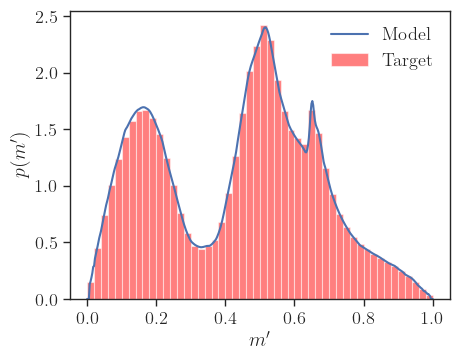

In [29]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(mp, pmp, lw=1.5, label = r'$\mathrm{Model}$')
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r'$p(m^\prime)$')

# Plot the histograms for comparison
counts, bins, _ = ax.hist(mp_thetap[:,1], 50, alpha = 0.5, label = r'$\mathrm{Target}$', density = True, color = 'red')
#ax.hist(mp_thetap_gen[:,1], bins, alpha=0.5, label = r'$\mathrm{Generated}$', density = True)
ax.legend(loc='best', frameon=False)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_target_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

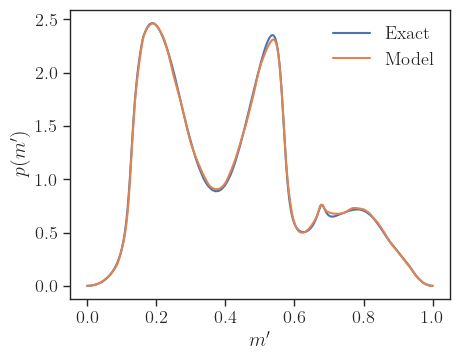

In [26]:
# Let's see if we can get the exact likelihood from the model that produced the training data
mprime_exact = np.load('data/D_Kpipi_mprime.npy')
dens_m = np.load('data/D_Kpipi_dGamma_dmprime.npy')

fig, ax = plt.subplots(1,1,figsize=(5,4))
# Plot model likelihood
ax.plot(mprime_exact, dens_m, lw=1.5, label = r'$\mathrm{Exact}$')
# Plot model likelihood
ax.plot(thetap, pthetap, lw=1.5, label = r'$\mathrm{Model}$')
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r'$p(m^\prime)$')
ax.legend(loc='best', frameon=False)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_exact_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_mp_INN_exact_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

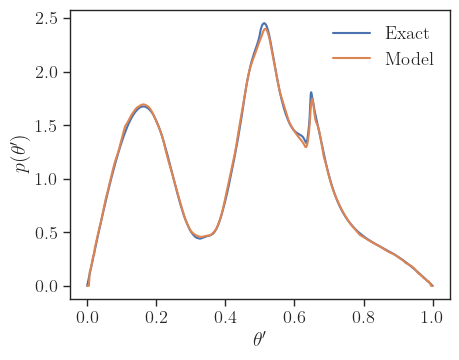

In [27]:
thetaprime_exact = np.load('data/D_Kpipi_thetaprime.npy')
dens_thetaprime = np.load('data/D_Kpipi_dGamma_dthetaprime.npy')

fig, ax = plt.subplots(1,1,figsize=(5,4))
# Plot model likelihood
ax.plot(thetaprime_exact, dens_thetaprime, lw=1.5, label = r'$\mathrm{Exact}$')
# Plot model likelihood
ax.plot(mp, pmp, lw=1.5, label = r'$\mathrm{Model}$')
ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r'$p(\theta^\prime)$')
ax.legend(loc='best', frameon=False)
fig.tight_layout()
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_exact_vs_model.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')
#fig.savefig(r'figs/D_amplitude_SDP_thetap_INN_exact_vs_model.png', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

In [60]:
from DKpp import DKpp

In [61]:
@torch.no_grad()
def conditional_pdf(
    flow,
    fixed_value,
    fixed_axis=0,         # 0 → fix x1=m', 1 → fix x2=θ'
    nx=400,
    on_unit_box=True,
    eps=1e-8,
    data_range=None,
    device=None,
):
    """
    Compute conditional density p(x_free | x_fixed=fixed_value).

    Returns:
        xs   (np.ndarray): grid values of the free variable
        pdf  (np.ndarray): normalized conditional density over xs
        logp (np.ndarray): unnormalized log joint for inspection
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    flow = flow.to(device).eval()

    # ranges
    if on_unit_box:
        xmin, xmax = eps, 1.0 - eps
        ymin, ymax = eps, 1.0 - eps
    else:
        if data_range is None:
            xmin, xmax = -3.0, 3.0
            ymin, ymax = -3.0, 3.0
        else:
            (xmin, xmax), (ymin, ymax) = data_range

    # grid over the free variable
    if fixed_axis == 0:
        xs = np.linspace(ymin, ymax, nx, dtype=np.float32)
        pts = np.stack([np.full_like(xs, fixed_value, dtype=np.float32), xs], axis=1)
    else:
        xs = np.linspace(xmin, xmax, nx, dtype=np.float32)
        pts = np.stack([xs, np.full_like(xs, fixed_value, dtype=np.float32)], axis=1)

    pts_t = torch.from_numpy(pts).to(device)

    # joint log-prob for each slice point
    logp = flow.log_prob(pts_t).cpu().numpy()
    pdf = np.exp(logp - logp.max())       # stabilize
    pdf /= np.trapz(pdf, xs)              # normalize to 1

    return xs, pdf, logp

/home/tony/miniconda3/envs/hadronization_mlrw/lib/python3.12/site-packages/nflows/transforms/coupling.py:481: UserWarning: Inputs to the softmax are not scaled down: initialization might be bad.
  warnings.warn(


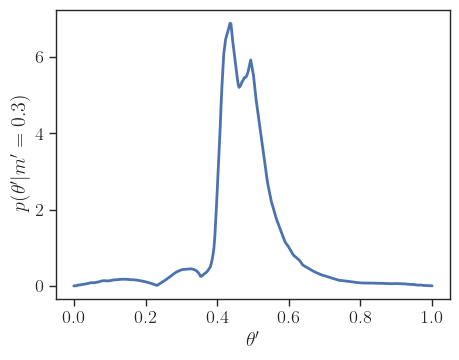

In [67]:
xs, pdf, logp = conditional_pdf(flow, fixed_value=0.3, fixed_axis=0,
                                nx=400, on_unit_box=True)

fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(xs, pdf, lw = 2)
ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r"$p(\theta' | m'=0.3)$")
fig.tight_layout()

In [70]:
# Map m' -> m12 and s12
def mprime_to_m12(mprime, mmin, mmax):
    """CLEO/BaBar/Belle convention: m'(0)=mmax, m'(1)=mmin."""
    dM = mmax - mmin
    return mmin + 0.5*dM*(1.0 + np.cos(np.pi*mprime))

# Map theta' -> s13 along the kinematic arc at fixed s12
def thetap_to_s13(thetap, s13min, s13max):
    # Now θ'=0 -> s13min, θ'=1 -> s13max (increasing order)
    return 0.5*(s13max + s13min) - 0.5*(s13max - s13min)*np.cos(np.pi*thetap)

# Full Jacobian |\partial(s12,s13)/\partial(m',\theta')|
def jacobian(mprime, thetap, mmin, mmax, s13min, s13max):
    m12  = mprime_to_m12(mprime, mmin, mmax)
    dM   = (mmax - mmin)
    ds12_dmp  = -np.pi * dM * m12 * np.sin(np.pi*mprime)              # magnitude will be taken
    ds13_dthp = -0.5*np.pi * (s13max - s13min) * np.sin(np.pi*thetap) # magnitude will be taken
    return np.abs(ds12_dmp) * np.abs(ds13_dthp)

# Kallen function
def kallen(x,y,z):
    return x*x + y*y + z*z - 2*(x*y + x*z + y*z)

# Generic limits: given sij, return sik^{min,max}
# PDG three-body kinematics (M = parent mass, mi = masses of i,j,k)
def sik_limits_given_sij(sij, M, mi, mj, mk):
    M2 = M*M
    mi2, mj2, mk2 = mi*mi, mj*mj, mk*mk
    s = np.asarray(sij)
    # central term
    num = (s + mi2 - mj2)*(M2 - s - mk2)
    # phase-space term
    root = np.sqrt(np.maximum(kallen(s, mi2, mj2) * kallen(M2, s, mk2), 0.0))
    den = 2*s
    sik_max = mi2 + mk2 + (num + root)/den
    sik_min = mi2 + mk2 + (num - root)/den
    return sik_min, sik_max

In [71]:
def abs_ds13_dthetap(thetap, s13min, s13max):
    # |∂s13/∂θ'| for the square-Dalitz mapping
    return 0.5*np.pi*(s13max - s13min)*np.abs(np.sin(np.pi*thetap))

def abs_ds12_dmprime(mprime, mmin, mmax):
    # |∂s12/∂m'|
    m12 = mprime_to_m12(mprime, mmin, mmax)
    dM  = (mmax - mmin)
    return np.pi * dM * m12 * np.abs(np.sin(np.pi*mprime))

In [72]:
def conditional_theta_given_mprime(amp_obj, mprime, n_theta=400):
    """
    Returns (thetap_grid, pdf_theta), normalized so that ∫_0^1 pdf(θ'|m') dθ' = 1.
    """
    M  = amp_obj.M()
    m1, m2, m3 = amp_obj.m1(), amp_obj.m2(), amp_obj.m3()
    mmin = m1 + m2
    mmax = M  - m3

    # fixed s12 from m'
    m12 = mprime_to_m12(mprime, mmin, mmax)
    s12 = m12*m12

    # θ' grid (uniform is fine; we include the Jacobian below)
    thetap = np.linspace(0.0, 1.0, n_theta)

    # kinematic limits and map θ' -> s13(θ')
    s13min, s13max = sik_limits_given_sij(s12, M, m1, m2, m3)
    s13 = thetap_to_s13(thetap, s13min, s13max)

    # evaluate |A|^2 on the slice (m' fixed, θ' varying)
    pts = np.column_stack([np.full_like(s13, s12), s13])
    A = amp_obj.full(pts)
    mod2 = (A.real*A.real + A.imag*A.imag)

    # Conditional density ∝ |A|^2 * |∂s13/∂θ'|
    dens = mod2 * abs_ds13_dthetap(thetap, s13min, s13max)

    # normalize to unit area over θ'
    area = np.trapz(dens, thetap)
    pdf  = dens / (area + 1e-300)
    return thetap, pdf

# ================================================================
# p(m' | θ'): conditional PDF of m' at fixed θ'  (slice in m')
# ================================================================
def conditional_mprime_given_theta(amp_obj, thetap, n_mprime=400):
    """
    Returns (mprime_grid, pdf_mprime), normalized so that ∫_0^1 pdf(m'|θ') dm' = 1.
    """
    M  = amp_obj.M()
    m1, m2, m3 = amp_obj.m1(), amp_obj.m2(), amp_obj.m3()
    mmin = m1 + m2
    mmax = M  - m3

    # m' grid (uniform; include |∂s12/∂m'| Jacobian below)
    mprime = np.linspace(0.0, 1.0, n_mprime)

    # for each m', build s12(m') and s13(θ' ; s12)
    m12 = mprime_to_m12(mprime, mmin, mmax)
    s12 = m12*m12
    s13min, s13max = sik_limits_given_sij(s12, M, m1, m2, m3)  # vectorized over m'
    s13 = thetap_to_s13(thetap, s13min, s13max)

    pts = np.column_stack([s12, s13])
    A = amp_obj.full(pts)
    mod2 = (A.real*A.real + A.imag*A.imag)

    # Conditional density ∝ |A|^2 * |∂s12/∂m'|
    dens = mod2 * abs_ds12_dmprime(mprime, mmin, mmax)

    # normalize to unit area over m'
    area = np.trapz(dens, mprime)
    pdf  = dens / (area + 1e-300)
    return mprime, pdf

In [75]:
dk = DKpp()

# Slice at fixed m' (e.g., m' = 0.35)
thp, p_th_given_m = conditional_theta_given_mprime(dk, mprime=0.3, n_theta=600)

# Slice at fixed θ' (e.g., θ' = 0.60)
mp, p_m_given_th = conditional_mprime_given_theta(dk, thetap=0.20, n_mprime=600)

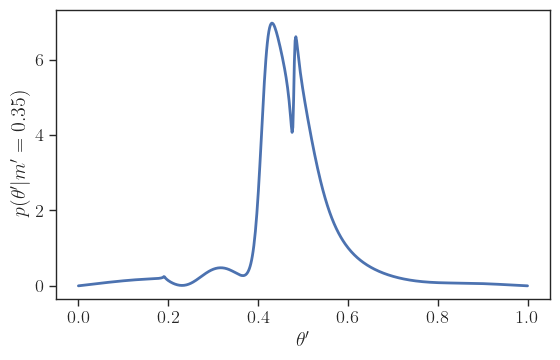

In [76]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(thp, p_th_given_m, lw=2)
ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r"$p(\theta'|m'=0.35)$")
fig.tight_layout()

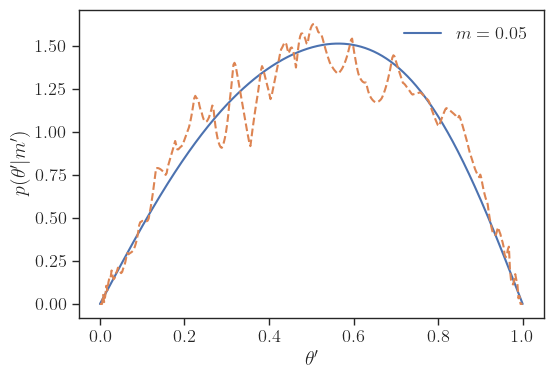

In [ ]:
# Define a set of m' slices
mprime_slices = [0.05]#np.linspace(0.05, 0.95, 10)

fig, ax = plt.subplots(1,1,figsize=(6,4))
for mprime in mprime_slices:
    # Compute the exact conditional
    thp, p_th_given_m = conditional_theta_given_mprime(dk, mprime=mprime, n_theta=600)
    ax.plot(thp, p_th_given_m, lw=1.5, label = rf'$m = {mprime:.2f}$')

    # Compute the model conditional
    xs, pdf, logp = conditional_pdf(flow, fixed_value=mprime, fixed_axis=0,
                                    nx=400, on_unit_box=True)
    ax.plot(xs, pdf, '--', lw=1.5)

ax.set_xlabel(r"$\theta'$")
ax.set_ylabel(r"$p(\theta'|m')$")
ax.legend(loc='best', frameon=False)
#fig.tight_layout()

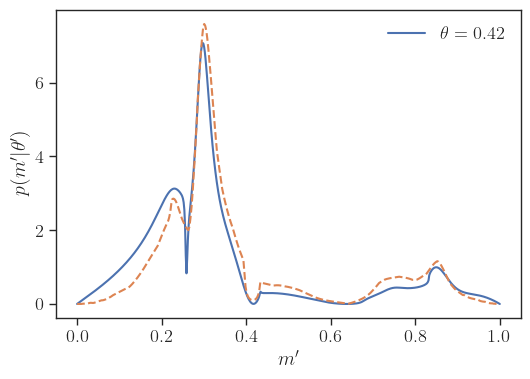

In [107]:
thetap_slices = [0.42]#np.linspace(0.05, 0.95, 10)

fig, ax = plt.subplots(1,1,figsize=(6,4))
for thetap in thetap_slices:
    # Compute the exact conditional
    mp, p_m_given_th = conditional_mprime_given_theta(dk, thetap=thetap, n_mprime=600)
    ax.plot(mp, p_m_given_th, lw=1.5, label = rf'$\theta = {thetap:.2f}$')

    # Compute the model conditional
    xs, pdf, logp = conditional_pdf(flow, fixed_value=thetap, fixed_axis=1,
                                    nx=400, on_unit_box=True)
    ax.plot(xs, pdf, '--', lw=1.5)

ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$p(m'|\theta')$")
ax.legend(loc='best', frameon=False)